# This notebook gives 
## X_train, y_train
## X_val, y_val
## X_test

In [6]:
import pandas as pd
import numpy as np

import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing 
from scipy.optimize import minimize
from sklearn import metrics

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from datetime import datetime
import nltk
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords



In [13]:
train = pd.read_csv (r'/Users/christineshen/Desktop/NYU/Spring 2020/ML 1003/project/train.csv')
val = pd.read_csv (r'/Users/christineshen/Desktop/NYU/Spring 2020/ML 1003/project/dev.csv')
test = pd.read_csv(r'/Users/christineshen/Desktop/NYU/Spring 2020/ML 1003/project/test_no_label.csv').drop('label', axis = 1)

In [14]:
print("Training data:   ", train.shape)
print("Validation data: ", val.shape)
print("Test data:       ", test.shape)  # no label


Training data:    (250874, 7)
Validation data:  (35918, 7)
Test data:        (72165, 6)


In [15]:
train.head(10)

,ex_id,user_id,prod_id,rating,label,date,review
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...
1,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...
2,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...
3,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...
4,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...
5,5,928,0,4.0,1,2009-09-02,A solid 4 stars for this greek food spot. If ...
6,7,930,0,4.0,1,2007-05-20,Love this place! Try the Chicken sandwich or ...
7,8,931,0,4.0,1,2005-12-27,My friend and I were intrigued by the nightly ...
8,10,933,0,5.0,1,2014-01-21,pretty cool place...good food...good people
9,12,935,0,5.0,1,2011-01-31,Fabulous Authentic Greek Food!!! This little s...


## TF-IDF Vectorization

In [16]:
train_corpus = train['review']
val_corpus = val['review']
test_corpus=test['review']

In [17]:
tf = TfidfVectorizer(binary = False, ngram_range = (1,2), stop_words = 'english',min_df=0.01,max_df=0.3)

In [18]:
train_tfidf = tf.fit_transform(train_corpus)

In [19]:
print(train_tfidf.shape)

(250874, 923)


In [20]:
print(type(train_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


In [21]:
train_features=train_tfidf.toarray()   #convert to numpy array

In [22]:
val_tfidf=tf.transform(val_corpus)

In [23]:
val_features=val_tfidf.toarray()

In [24]:
val_features.shape

(35918, 923)

In [25]:
test_tfidf=tf.transform(test_corpus)

In [26]:
test_features=test_tfidf.toarray()

In [27]:
test_features.shape

(72165, 923)

###  Add the column for rating and divide by 5 to bring the value between [0,1]

In [28]:
X_train=np.c_[train_features,train['rating'].values/5] 

In [29]:
X_val=np.c_[val_features,val['rating'].values/5]

In [30]:
X_test=np.c_[test_features,test['rating'].values/5]

In [22]:
#X_val[:,-1][:10]*5 #check top 10

In [23]:
#X_test[:,-1][:10]*5 #check top 10

In [31]:
y_train = train['label'].values
y_val = val['label'].values

## Processed Data for Training, Validation and Testing:

In [32]:
print("Training data is ", X_train.shape, "and labels are ", y_train.shape)

Training data is  (250874, 924) and labels are  (250874,)


In [33]:
print("Validation data is ", X_val.shape, "and labels are ", y_val.shape)

Validation data is  (35918, 924) and labels are  (35918,)


In [34]:
print("Test data is ", X_test.shape, "and labels will be predicted by model ")

Test data is  (72165, 924) and labels will be predicted by model 


In [ ]:
#np.savetxt('X_train.csv', X_train, delimiter=',')

In [35]:
np.savetxt('y_val.csv', y_val)

## Reference:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer

## In Training set:
The fake reviews (+1) are 25819 and genuine reviews (0) are 225055 out of total 250874 samples. 
10.29 % fake reviews.

## In Validation set:
The fake reviews (+1) are 3648 and genuine reviews (0) are 32270 out of total 35918 samples.
10.16 % fake reviews.

# ---------------------------------------------------------------------------------------

## SMOTE & under sampling majority class

In [38]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [39]:
X_train, y_train = pipeline.fit_resample(X_train, y_train)


In [51]:
X_val, y_val = pipeline.fit_resample(X_val, y_val)

## Model

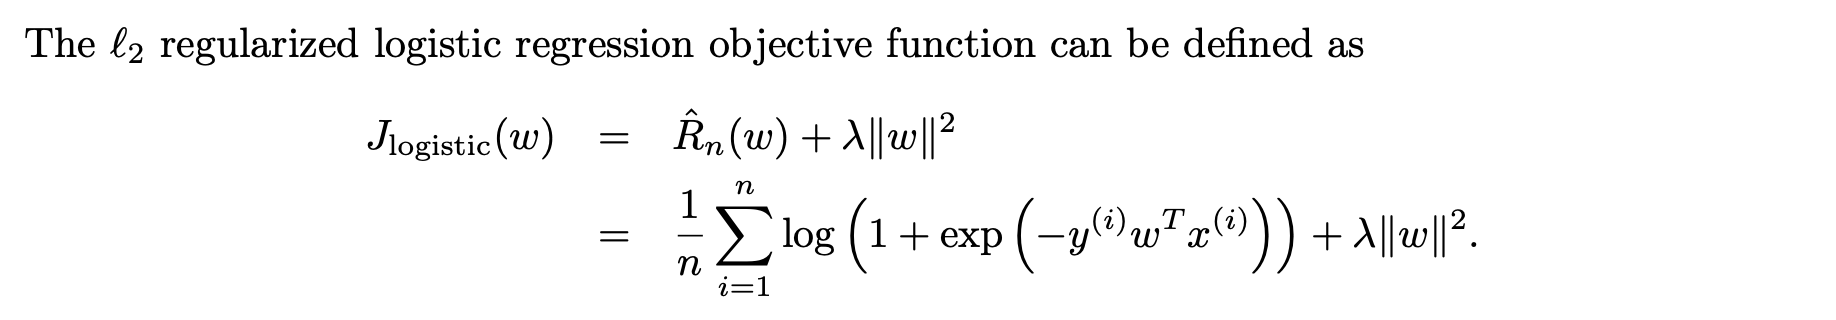

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings


In [41]:
np.logspace(-3,3,7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [52]:
X_full=np.r_[X_train,X_val]
X_full.shape

(154395, 924)

In [53]:
y_full=np.r_[y_train,y_val]
y_full.shape

(154395,)

In [54]:
warnings.filterwarnings('ignore')
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10,scoring='roc_auc')
logreg_cv.fit(X_full,y_full)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)



tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2'}
accuracy : 0.7802039154626182


In [55]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2'}
accuracy : 0.7802039154626182


In [56]:
warnings.filterwarnings('ignore')

clf_lr_w= LogisticRegression(penalty='l2',C=0.1,class_weight='balanced') 
clf_lr_w.fit(X_train,y_train)


LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
probs_w = clf_lr_w.predict_proba(X_val)[:,1]  # probability for label=1

In [58]:
fpr_w,tpr_w,threshold_w = metrics.roc_curve(y_val, probs_w)
auc_w = metrics.auc(fpr_w,tpr_w)
auc_w

0.7855253668088886

In [59]:
p = clf_lr_w.predict_proba(X_train)[:,1]  # probability for label=1
f,t,thres = metrics.roc_curve(y_train, p)
auc_train = metrics.auc(f,t)
auc_train

0.7928088631089628

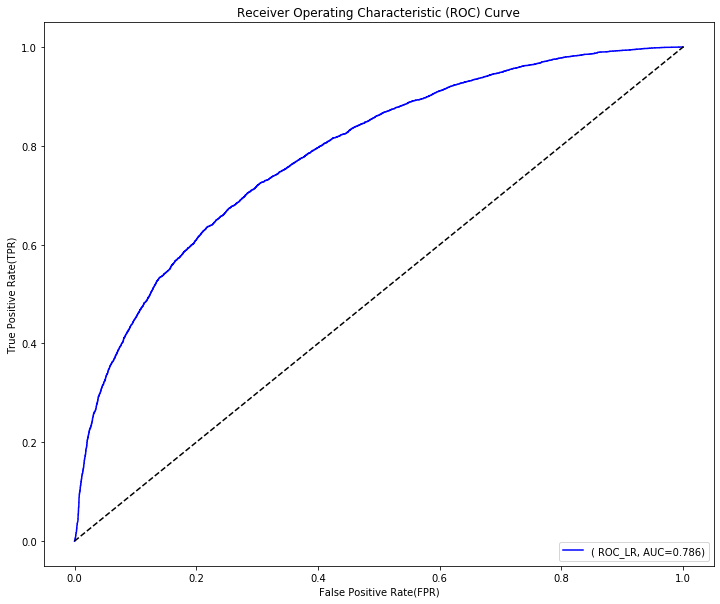

In [60]:
plt.figure(figsize=(12 ,10))
#plt.plot(fpr, tpr, color='red', label='( ROC_LR, AUC=%0.3f)'%auc)
plt.plot(fpr_w, tpr_w, color='blue', label='( ROC_LR, AUC=%0.3f)'%auc_w)

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc=4) #4:lower right legend
